# Setting Device To Cuda For GPU Execution

In [5]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Loading Image and Label Paths

In [8]:
DATA_ROOT = '/kaggle/input/retinal-disease-classification'

train_dir = os.path.join(DATA_ROOT, 'Training_Set', 'Training_Set')
val_dir = os.path.join(DATA_ROOT, 'Evaluation_Set', 'Evaluation_Set')
test_dir = os.path.join(DATA_ROOT, 'Test_Set', 'Test_Set')

train_img_paths = glob.glob(os.path.join(train_dir, 'Training', '*.png'))
train_label_path = os.path.join(train_dir, 'RFMiD_Training_Labels.csv')

val_img_paths = glob.glob(os.path.join(val_dir, 'Validation', '*.png'))
val_label_path = os.path.join(val_dir, 'RFMiD_Validation_Labels.csv')

test_img_paths = glob.glob(os.path.join(test_dir, 'Test', '*.png'))
test_label_path = os.path.join(test_dir, 'RFMiD_Testing_Labels.csv')

len(train_img_paths), len(val_img_paths), len(test_img_paths)

(1920, 640, 640)

In [9]:
train_label_df = pd.read_csv(train_label_path)
val_label_df = pd.read_csv(val_label_path)
test_label_df = pd.read_csv(test_label_path)

print(f'Num. train labels: {len(train_label_df)}')
print(f'Num. val labels: {len(val_label_df)}')
print(f'Num. test labels: {len(test_label_df)}')

Num. train labels: 1920
Num. val labels: 640
Num. test labels: 640


In [10]:
# show labels in train set
train_label_df

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,CME,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,1916,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1916,1917,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1917,1918,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1918,1919,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Visualizing The Images And Labels

There are 47 columns. Out of which, the `ID` column is the retina image ID, `Disease_Risk` is a binary column representing whether the retina is normal or not. The remaining 45 columns are different types of retina diseases

In [11]:
train_label_df.columns, len(train_label_df.columns)

(Index(['ID', 'Disease_Risk', 'DR', 'ARMD', 'MH', 'DN', 'MYA', 'BRVO', 'TSLN',
        'ERM', 'LS', 'MS', 'CSR', 'ODC', 'CRVO', 'TV', 'AH', 'ODP', 'ODE', 'ST',
        'AION', 'PT', 'RT', 'RS', 'CRS', 'EDN', 'RPEC', 'MHL', 'RP', 'CWS',
        'CB', 'ODPM', 'PRH', 'MNF', 'HR', 'CRAO', 'TD', 'CME', 'PTCR', 'CF',
        'VH', 'MCA', 'VS', 'BRAO', 'PLQ', 'HPED', 'CL'],
       dtype='object'),
 47)

Since this is a `multi-label classification` problem, each sample might have zero, one, or more than one true labels. In this case, each retina image might have multiple diseases.

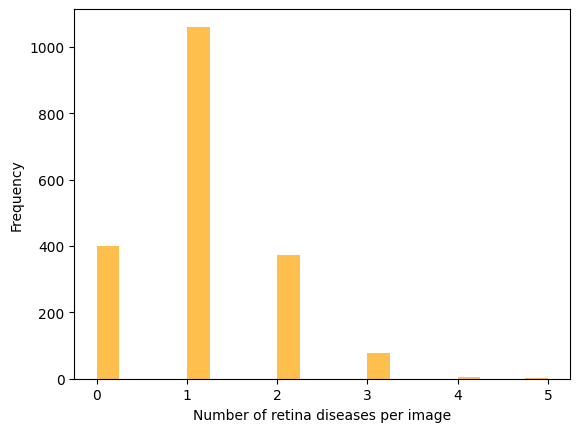

In [12]:
n_diseases_per_sample = train_label_df.drop(columns=['ID', 'Disease_Risk']).sum(axis=1)

plt.hist(n_diseases_per_sample, bins=20, color='orange', alpha=0.7)
plt.xlabel('Number of retina diseases per image')
plt.ylabel('Frequency')
plt.show()

## Let's plot a normal retinal image and one with 5 diseases to compare the differences

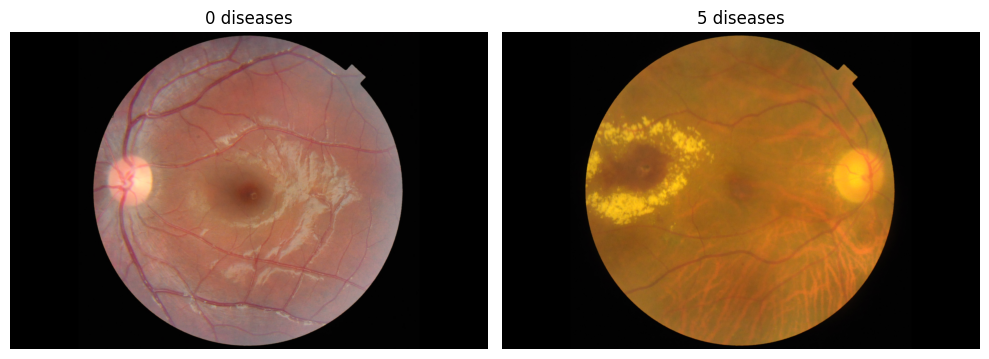

In [13]:
id_0di = (n_diseases_per_sample == 0).idxmax()
id_5di = (n_diseases_per_sample == 5).idxmax()

img_0di_path = os.path.join(train_dir, 'Training', f'{id_0di+1}.png')
img_5di_path = os.path.join(train_dir, 'Training', f'{id_5di+1}.png')

def load_img(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

img_0di, img_5di = load_img(img_0di_path), load_img(img_5di_path)

# Plot the images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img_0di)
plt.title('0 diseases')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_5di)
plt.title('5 diseases')
plt.axis('off')

plt.tight_layout()
plt.show()

## Each Image from 0 to 5 diseases

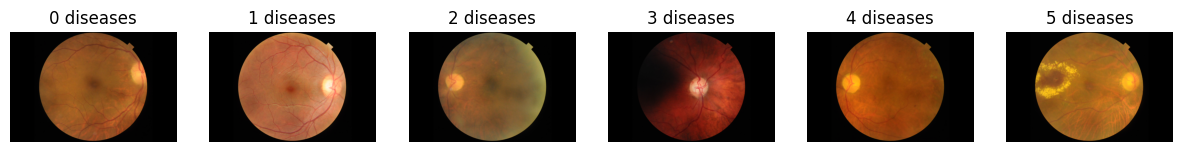

In [14]:
plt.figure(figsize=(15, 5))
np.random.seed(42)

for i in range(6):  # 0 to 5 diseases
    indices_i = n_diseases_per_sample.index[n_diseases_per_sample == i].tolist()
    if indices_i:
        id_i = np.random.choice(indices_i)  # Get a random index for the current disease count
        img_i_path = os.path.join(train_dir, 'Training', f'{id_i+1}.png')
        img_i = load_img(img_i_path)

        plt.subplot(1, 6, i + 1)
        plt.imshow(img_i)
        plt.title(f'{i} diseases')
        plt.axis('off')

plt.show()

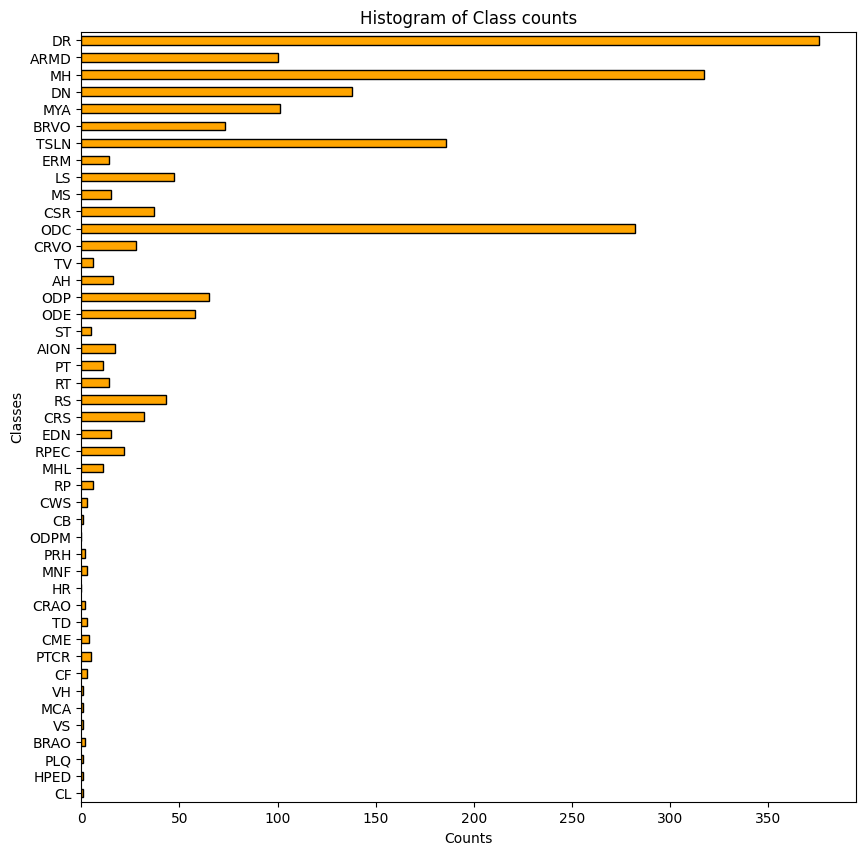

In [15]:
classes_freq = train_label_df.drop(columns=['ID', 'Disease_Risk']).sum(axis=0)[::-1]

plt.figure(figsize=(10, 10))  # Adjust the width and height as needed
classes_freq.plot(kind='barh', color='orange', edgecolor='black')

plt.title('Histogram of Class counts')
plt.xlabel('Counts')
plt.ylabel('Classes')

plt.show()

### Dropping columns with zero appearance of positive samples during training

In [16]:
classes_freq.loc[classes_freq == 0]

HR      0
ODPM    0
dtype: int64

# Preprocessing Data For Training

In [17]:
from torch.utils.data import Dataset
from PIL import Image

def path2id(img_path):
    return int(os.path.splitext(os.path.basename(img_path))[0])

class RetinaDataset(Dataset):
    
    def __init__(self, img_paths, label_csv_path, transform=None):
        self.img_paths = sorted(img_paths)
        self.label_df = pd.read_csv(label_csv_path).drop(columns=['ID', 'Disease_Risk', 'HR', 'ODPM'])
        self.transform = transform
    
    def __len__(self): 
        return len(self.img_paths)
    
    def __getitem__(self, id):
        img_path = self.img_paths[id]
        img_id = path2id(img_path)
        img = Image.open(img_path)
        label = np.array(self.label_df.iloc[img_id - 1]) # Index to frame is image ID - 1, see the note earlier
        if self.transform is not None:
            img = self.transform(img)
            label = torch.from_numpy(label).float()
        else:
            img = np.array(img)
        return img, label

In [18]:
#Image Dimension And Class Dimension
ID = 0

data = RetinaDataset(train_img_paths, train_label_path)

img, label = data[ID]
img.shape, img.dtype, label.shape, label.dtype

((1424, 2144, 3), dtype('uint8'), (43,), dtype('int64'))

# Image Augmentation & Transformations

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

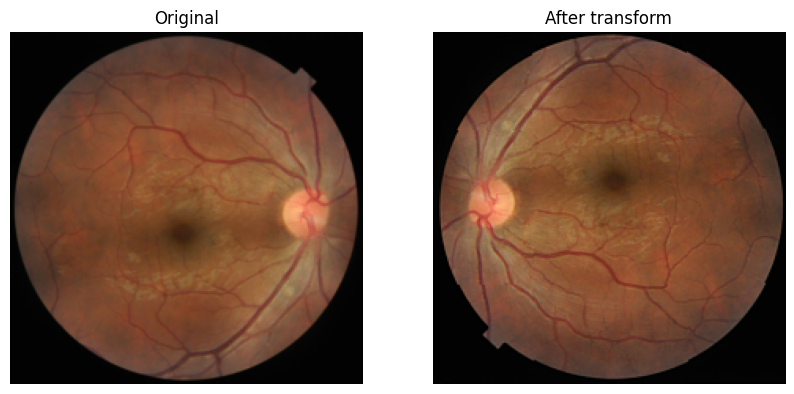

In [19]:
import torchvision.transforms.v2 as transforms

img_path = train_img_paths[8]
img = Image.open(img_path)

tf1 = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
])

tf2 = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomAdjustSharpness(2, 1),
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.CenterCrop(224),
])

img1, img2 = tf1(img), tf2(img)

plt.figure(figsize=(10,5))

plt.subplot(121)
plt.axis('off')
plt.title('Original')
plt.imshow(img1)

plt.subplot(122)
plt.title('After transform')
plt.imshow(img2)
plt.axis('off')
plt.show()

### Using PRE-Trained Means For Normalization Of ConvNext Model (Similar to VIT)

In [20]:
import torchvision.transforms.v2 as transforms

PRET_MEANS = [0.485, 0.456, 0.406]
PRET_STDS = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomAdjustSharpness(2, 0.8),
    transforms.RandomRotation(180),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.CenterCrop(224),
    transforms.ToImageTensor(),
    transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize(mean=PRET_MEANS, std=PRET_STDS)
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToImageTensor(),
    transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize(mean=PRET_MEANS, std=PRET_STDS)
])

In [21]:
train_data = RetinaDataset(train_img_paths, train_label_path, train_transform)
val_data = RetinaDataset(val_img_paths, val_label_path, test_transform)
test_data = RetinaDataset(test_img_paths, test_label_path, test_transform)

img, label = train_data[ID]
img.shape, img.dtype, label.shape, label.dtype

(torch.Size([3, 224, 224]), torch.float32, torch.Size([43]), torch.float32)

# Defining DataLoader

In [22]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64
# WEIGHT_DECAY = 1e-5
N_WORKERS = os.cpu_count()

train_loader = DataLoader(train_data,
                           batch_size=BATCH_SIZE,
                           shuffle=True,
                           num_workers=N_WORKERS,
                           pin_memory=True)

val_loader = DataLoader(val_data,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=N_WORKERS,
                         pin_memory=True)

test_loader = DataLoader(test_data,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=N_WORKERS,
                         pin_memory=True)

# VIT Model Loading & Configuration

In [26]:
import torch
from transformers import ViTForImageClassification, AdamW

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Number of classes (43 in total for retinal disease classification)
num_classes = 43

# Load the pre-trained ViT model with the correct number of labels
vit_model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=num_classes
)

# Move the model to the appropriate device (GPU or CPU)
vit_model.to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

# Model Training

In [28]:
# Define the optimizer and loss function
optimizer = AdamW(vit_model.parameters(), lr=5e-5)
loss_fn = torch.nn.BCEWithLogitsLoss()  # For multi-label classification

# Training loop with early stopping
def train_model(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, patience=5):
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        train_loss = 0.0
        train_correct = 0
        total_train = 0

        # Training step
        for batch in train_loader:
            imgs, labels = batch
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(imgs).logits
            loss = loss_fn(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = torch.sigmoid(outputs) > 0.5  # Binary classification per label
            train_correct += (preds == labels).sum().item()
            total_train += labels.numel()  # Total elements for accuracy calculation

        train_accuracy = train_correct / total_train

        # Validation step
        model.eval()
        val_loss = 0.0
        val_correct = 0
        total_val = 0

        with torch.no_grad():
            for batch in val_loader:
                imgs, labels = batch
                imgs, labels = imgs.to(device), labels.to(device)

                # Forward pass
                val_outputs = model(imgs).logits
                loss = loss_fn(val_outputs, labels)
                val_loss += loss.item()

                val_preds = torch.sigmoid(val_outputs) > 0.5
                val_correct += (val_preds == labels).sum().item()
                total_val += labels.numel()

        val_accuracy = val_correct / total_val

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

        # Check for validation loss improvement
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            # Save the model
            torch.save(model.state_dict(), 'best_model.pth')
            print("Validation loss improved, model saved.")
        else:
            epochs_without_improvement += 1

        # Early stopping
        if epochs_without_improvement >= patience:
            print(f'Early stopping activated. Stopped training after {epoch+1} epochs.')
            break

# Training the model using the DataLoader objects for training and validation
train_model(vit_model, optimizer, loss_fn, train_loader, val_loader, epochs=1000, patience=5)

Epoch 1/1000 - Train Loss: 15.1013, Train Acc: 0.9728, Val Loss: 4.4073, Val Acc: 0.9749
Validation loss improved, model saved.
Epoch 2/1000 - Train Loss: 12.1778, Train Acc: 0.9749, Val Loss: 3.7229, Val Acc: 0.9749
Validation loss improved, model saved.
Epoch 3/1000 - Train Loss: 10.3120, Train Acc: 0.9749, Val Loss: 3.1559, Val Acc: 0.9749
Validation loss improved, model saved.
Epoch 4/1000 - Train Loss: 8.7601, Train Acc: 0.9749, Val Loss: 2.6917, Val Acc: 0.9749
Validation loss improved, model saved.
Epoch 5/1000 - Train Loss: 7.5067, Train Acc: 0.9749, Val Loss: 2.3222, Val Acc: 0.9749
Validation loss improved, model saved.
Epoch 6/1000 - Train Loss: 6.5189, Train Acc: 0.9749, Val Loss: 2.0340, Val Acc: 0.9749
Validation loss improved, model saved.
Epoch 7/1000 - Train Loss: 5.7507, Train Acc: 0.9749, Val Loss: 1.8103, Val Acc: 0.9749
Validation loss improved, model saved.
Epoch 8/1000 - Train Loss: 5.1511, Train Acc: 0.9749, Val Loss: 1.6355, Val Acc: 0.9749
Validation loss impr

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7826ca470b80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7826ca470b80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
  File "/op

Epoch 52/1000 - Train Loss: 1.0167, Train Acc: 0.9926, Val Loss: 0.6098, Val Acc: 0.9821
Epoch 53/1000 - Train Loss: 0.9418, Train Acc: 0.9939, Val Loss: 0.5941, Val Acc: 0.9829
Validation loss improved, model saved.
Epoch 54/1000 - Train Loss: 0.9073, Train Acc: 0.9942, Val Loss: 0.5989, Val Acc: 0.9829
Epoch 55/1000 - Train Loss: 0.8728, Train Acc: 0.9944, Val Loss: 0.6064, Val Acc: 0.9825
Epoch 56/1000 - Train Loss: 0.8581, Train Acc: 0.9945, Val Loss: 0.5867, Val Acc: 0.9826
Validation loss improved, model saved.
Epoch 57/1000 - Train Loss: 0.8105, Train Acc: 0.9950, Val Loss: 0.5948, Val Acc: 0.9829
Epoch 58/1000 - Train Loss: 0.7879, Train Acc: 0.9951, Val Loss: 0.6021, Val Acc: 0.9820
Epoch 59/1000 - Train Loss: 0.7621, Train Acc: 0.9953, Val Loss: 0.5996, Val Acc: 0.9826
Epoch 60/1000 - Train Loss: 0.7500, Train Acc: 0.9953, Val Loss: 0.6057, Val Acc: 0.9822
Epoch 61/1000 - Train Loss: 0.7111, Train Acc: 0.9959, Val Loss: 0.5962, Val Acc: 0.9829
Early stopping activated. Stoppe

# Saving Model Locally

In [29]:
# Save the model to a local directory
vit_model.save_pretrained('vit_retinal_classification')

print("Model saved.")

Model saved.


# Loading the Model & Testing On Test Data

In [30]:
from transformers import ViTForImageClassification

# Load the saved model
vit_model = ViTForImageClassification.from_pretrained('vit_retinal_classification')

# Move the model to the appropriate device (GPU or CPU)
vit_model.to(device)

print("Model loaded successfully.")

# Ensure the test set is using the correct preprocessing (as done earlier for training and validation sets)
# Test data is already loaded via the `test_loader` DataLoader object

# Evaluate the model on the test set
vit_model.eval()  # Set the model to evaluation mode
test_loss = 0.0
test_correct = 0
total_test = 0

# Use Binary Cross Entropy for multi-label classification
loss_fn = torch.nn.BCEWithLogitsLoss()

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        # Forward pass
        test_outputs = vit_model(imgs).logits
        loss = loss_fn(test_outputs, labels)
        test_loss += loss.item()

        # Apply sigmoid to get probabilities and threshold them at 0.5 for binary classification
        test_preds = torch.sigmoid(test_outputs) > 0.5
        
        # Calculate correct predictions
        test_correct += (test_preds == labels).sum().item()
        total_test += labels.numel()

# Calculate test accuracy
test_accuracy = test_correct / total_test
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Model loaded successfully.
Test Loss: 0.5517, Test Accuracy: 0.9844


# Testing On One Image With Integrated Gradients For Feature Visibility

In [36]:
# Fetch one test sample (image and label)
for X_test, y_test in test_loader:
    X_test_tensor = X_test.to(device)  # Move to the appropriate device
    y_test_tensor = y_test.to(device)
    break  # Only take the first batch (image)

Number of disease labels after filtering: 43
Predicted diseases: ['DR', 'ODC']


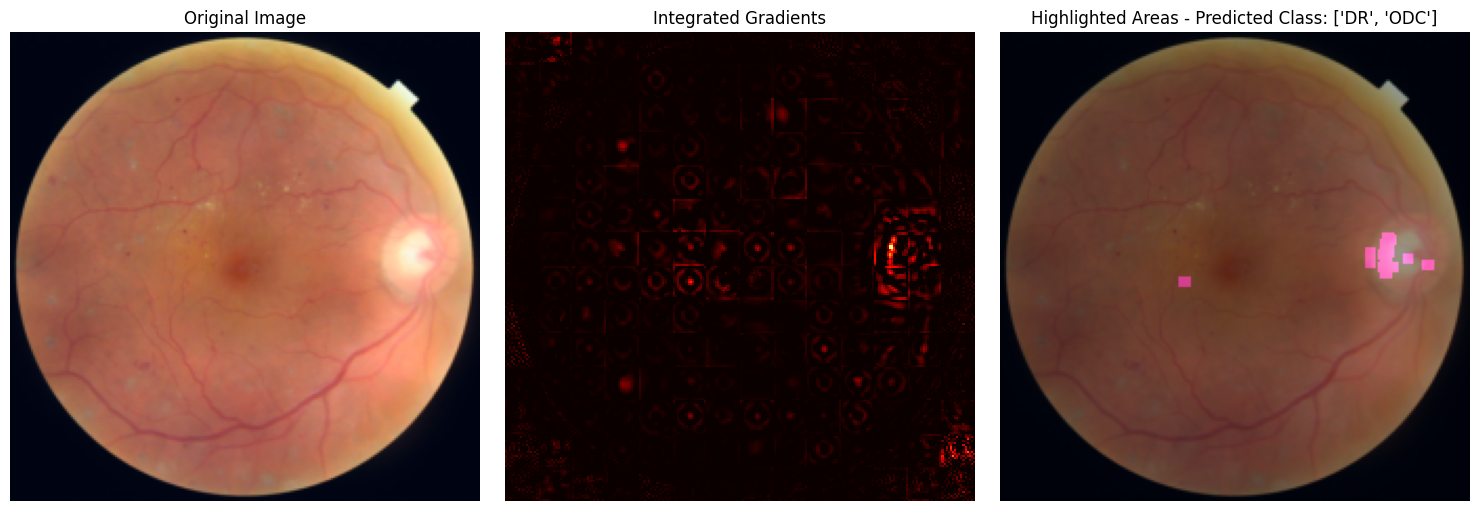

In [87]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from transformers import ViTForImageClassification, ViTFeatureExtractor

# Function to compute Integrated Gradients
def integrated_gradients(model, img, label, steps=50):
    model.eval()

    # Ensure the label is a scalar (1D tensor)
    label = label.unsqueeze(0) if label.ndim == 1 else label

    # Move the image and label to the device
    img = img.unsqueeze(0).to(device).requires_grad_(True)
    label = label.to(device)

    # Baseline: a black image
    baseline = torch.zeros_like(img).to(device)

    # Generate scaled images from baseline to the original image
    scaled_images = [baseline + (float(i) / steps) * (img - baseline) for i in range(steps + 1)]

    grads = []
    for scaled_img in scaled_images:
        output = model(scaled_img).logits

        # Compute loss with binary cross-entropy
        loss = torch.nn.functional.binary_cross_entropy_with_logits(output, label.float())
        model.zero_grad()
        loss.backward()

        # Store gradients
        grads.append(img.grad.data.cpu().numpy())

    # Calculate the average gradients across all scaled images
    avg_grads = np.mean(grads, axis=0)

    # Integrated Gradients: (input - baseline) * avg_grads
    integrated_grad = (img - baseline).detach().cpu().numpy() * avg_grads

    # Focus on positive contributions and normalize
    integrated_grad = np.maximum(integrated_grad.sum(axis=1), 0)
    integrated_grad -= integrated_grad.min()
    integrated_grad /= integrated_grad.max()

    return integrated_grad

# Load the test image and its true labels
test_img = X_test_tensor[1]  # Select the first test image
true_labels = y_test_tensor[1]  # True labels for the image (multi-labels)

# Extract disease labels, skipping 'ID', 'Disease_Risk', 'HR', and 'ODPM'
disease_labels = [label for label in train_label_df.columns[2:] if label not in ['HR', 'ODPM']]
print(f"Number of disease labels after filtering: {len(disease_labels)}")  # Should now be 43

# Make predictions with the model
vit_model.eval()
with torch.no_grad():
    output = vit_model(test_img.unsqueeze(0).to(device)).logits
predicted_probs = torch.sigmoid(output).squeeze().cpu().numpy()  # Convert logits to probabilities

# Ensure that predicted_probs and disease_labels have the same length
assert len(predicted_probs) == len(disease_labels), "Mismatch between number of probabilities and disease labels."

# Threshold to consider a disease as "predicted"
prob_threshold = 0.5
predicted_diseases = [disease_labels[i] for i in range(len(predicted_probs)) if predicted_probs[i] > prob_threshold]

# Print predicted diseases
print(f"Predicted diseases: {predicted_diseases}")

# Calculate Integrated Gradients
true_labels_reshaped = true_labels.unsqueeze(0)  # Reshape to [1, 43] for multi-label
attribution = integrated_gradients(vit_model, test_img, true_labels_reshaped)

# Squeeze the attribution to remove the singleton dimension
attribution = attribution.squeeze()

# Set a threshold to filter the most important areas
threshold = 0.3  # Adjust this value based on experimentation
important_areas = attribution > threshold

# Dilation to expand the highlighted areas
kernel = np.ones((5, 5), np.uint8)  # Create a kernel for dilation
dilated_areas = cv2.dilate(important_areas.astype(np.uint8), kernel, iterations=1)

# Load and process the original image
original_image = test_img.permute(1, 2, 0).cpu().numpy()
original_image = (original_image - original_image.min()) / (original_image.max() - original_image.min())
original_image = original_image.astype(np.float32)

# Create a mask for non-black areas in the original image
black_mask = (original_image.sum(axis=2) > 0.1)

# Create a color mask for highlighting
highlight_color = np.array([1, 0, 1])  # Magenta color in normalized format [1, 0, 1]
highlighted_image = np.zeros((*dilated_areas.shape, 3))

# Apply the highlight color only to important areas that are also non-black
highlighted_image[(dilated_areas == 1) & (black_mask)] = highlight_color

# Ensure highlighted_image is float32
highlighted_image = highlighted_image.astype(np.float32)

# Blend the original image with the highlighted areas
blended_image = cv2.addWeighted(original_image, 0.6, highlighted_image, 0.4, 0)

# Visualize the results
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(original_image)
plt.title("Original Image")
plt.axis('off')

# Attribution Map
plt.subplot(1, 3, 2)
plt.imshow(attribution, cmap='hot', interpolation='nearest')
plt.title("Integrated Gradients")
plt.axis('off')

# Highlighted Important Areas
plt.subplot(1, 3, 3)
plt.imshow(blended_image)
plt.title(f"Highlighted Areas - Predicted Class: {predicted_diseases}")
plt.axis('off')

plt.tight_layout()
plt.show()

# Corresponding Predicted Probability Of Each Label

In [88]:
predicted_probs

array([0.899905  , 0.02444595, 0.03197274, 0.04665355, 0.03890365,
       0.02299976, 0.07338133, 0.0187363 , 0.33850092, 0.02002573,
       0.0198142 , 0.91326416, 0.01295251, 0.02274681, 0.04347837,
       0.04161064, 0.01456808, 0.02201126, 0.0149456 , 0.01684653,
       0.02408375, 0.01566439, 0.02327389, 0.01497939, 0.02460994,
       0.02851702, 0.01440569, 0.01825656, 0.01410079, 0.01318085,
       0.01231647, 0.01870162, 0.01443666, 0.01620033, 0.01521011,
       0.01927414, 0.01645575, 0.01875258, 0.01346793, 0.01486595,
       0.01897545, 0.01389592, 0.01243093], dtype=float32)

# Predicting With User Input

Enter the path to the image you want to test:  /kaggle/input/retinal-disease-classification/Test_Set/Test_Set/Test/10.png


Number of disease labels after filtering: 43
Predicted diseases: ['DR', 'LS', 'ODC']


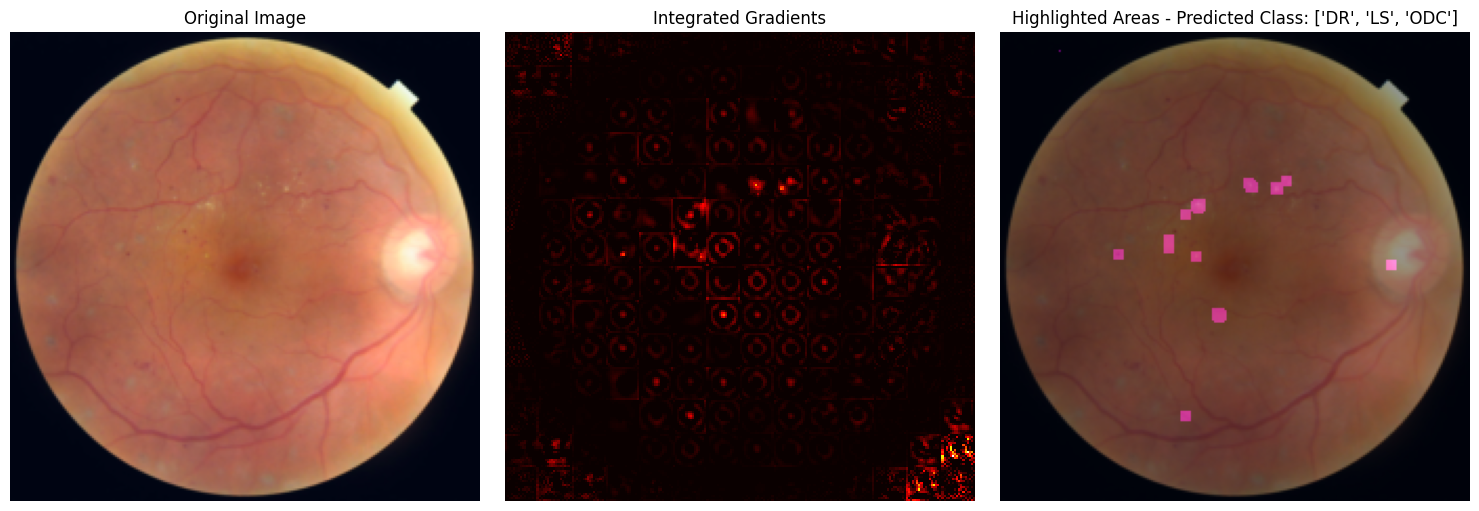

In [91]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from transformers import ViTForImageClassification, ViTFeatureExtractor
import os
from PIL import Image

# Function to load and preprocess the image from a given path
def load_and_preprocess_image(image_path):
    # Open the image
    image = Image.open(image_path).convert('RGB')  # Ensure the image is in RGB mode

    # Apply the same transformations as for the test dataset
    transform = test_transform  # Use the same test transformation defined earlier
    image_tensor = transform(image)  # Apply the transformations

    return image_tensor

# Get the image path from the user
image_path = input("Enter the path to the image you want to test: ")

# Check if the image file exists
if not os.path.isfile(image_path):
    print("Error: File not found.")
else:
    # Load and preprocess the image
    test_img = load_and_preprocess_image(image_path)
    
    # Extract disease labels, skipping 'ID', 'Disease_Risk', 'HR', and 'ODPM'
    disease_labels = [label for label in train_label_df.columns[2:] if label not in ['HR', 'ODPM']]
    print(f"Number of disease labels after filtering: {len(disease_labels)}")  # Should now be 43

    # Make predictions with the model
    vit_model.eval()
    with torch.no_grad():
        output = vit_model(test_img.unsqueeze(0).to(device)).logits

    predicted_probs = torch.sigmoid(output).squeeze().cpu().numpy()  # Convert logits to probabilities

    # Ensure that predicted_probs and disease_labels have the same length
    assert len(predicted_probs) == len(disease_labels), "Mismatch between number of probabilities and disease labels."

    # Threshold to consider a disease as "predicted"
    prob_threshold = 0.3
    predicted_diseases = [disease_labels[i] for i in range(len(predicted_probs)) if predicted_probs[i] > prob_threshold]

    # Print predicted diseases
    print(f"Predicted diseases: {predicted_diseases}")

    # Calculate Integrated Gradients
    # Assuming you have true_labels available for this particular case; 
    # In a real scenario, you might want to handle it differently.
    # Here we will create a dummy true_labels tensor just for demonstration
    true_labels_reshaped = torch.zeros(len(disease_labels)).to(device)  # Assuming no ground truth available

    # Calculate Integrated Gradients
    attribution = integrated_gradients(vit_model, test_img, true_labels_reshaped)

    # Squeeze the attribution to remove the singleton dimension
    attribution = attribution.squeeze()

    # Set a threshold to filter the most important areas
    threshold = 0.3  # Adjust this value based on experimentation
    important_areas = attribution > threshold

    # Dilation to expand the highlighted areas
    kernel = np.ones((5, 5), np.uint8)  # Create a kernel for dilation
    dilated_areas = cv2.dilate(important_areas.astype(np.uint8), kernel, iterations=1)

    # Load and process the original image for visualization
    original_image = test_img.permute(1, 2, 0).cpu().numpy()
    original_image = (original_image - original_image.min()) / (original_image.max() - original_image.min())
    original_image = original_image.astype(np.float32)

    # Create a mask for non-black areas in the original image
    black_mask = (original_image.sum(axis=2) > 0.1)

    # Create a color mask for highlighting
    highlight_color = np.array([1, 0, 1])  # Magenta color in normalized format [1, 0, 1]
    highlighted_image = np.zeros((*dilated_areas.shape, 3))

    # Apply the highlight color only to important areas that are also non-black
    highlighted_image[(dilated_areas == 1) & (black_mask)] = highlight_color

    # Ensure highlighted_image is float32
    highlighted_image = highlighted_image.astype(np.float32)

    # Blend the original image with the highlighted areas
    blended_image = cv2.addWeighted(original_image, 0.6, highlighted_image, 0.4, 0)

    # Visualize the results
    plt.figure(figsize=(15, 5))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis('off')

    # Attribution Map
    plt.subplot(1, 3, 2)
    plt.imshow(attribution, cmap='hot', interpolation='nearest')
    plt.title("Integrated Gradients")
    plt.axis('off')

    # Highlighted Important Areas
    plt.subplot(1, 3, 3)
    plt.imshow(blended_image)
    plt.title(f"Highlighted Areas - Predicted Class: {predicted_diseases}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
# Classification Report & Confusion Matrix Code (Review) == Wrong Plots

In [6]:
from transformers import ViTForImageClassification

# Load the saved model
vit_model = ViTForImageClassification.from_pretrained('mandarchaudharii/retinal_multiclass')

# Move the model to the appropriate device (GPU or CPU)
vit_model.to(device)

print("Model loaded successfully.")

Model loaded successfully.


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Accumulate true labels and predictions
all_labels = []
all_preds = []

vit_model.eval()  # Set model to evaluation mode

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        # Forward pass
        test_outputs = vit_model(imgs).logits

        # Apply sigmoid and threshold for binary predictions
        test_preds = torch.sigmoid(test_outputs) > 0.5

        # Store predictions and true labels
        all_preds.append(test_preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Convert lists to numpy arrays
all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Calculate confusion matrix for each class
for i in range(all_labels.shape[1]):
    cm = confusion_matrix(all_labels[:, i], all_preds[:, i])
    print(f"Confusion Matrix for Class {i}:")
    print(cm)

    # Plot confusion matrix using seaborn heatmap
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f'Confusion Matrix for Class {i}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=[f'Class {i}' for i in range(all_labels.shape[1])]))